# Energy Spread Analysis

We are looking at two different future pairs. 
- **ICE Brent Crude Oil B**(ICE_B_B) and **ICE Gas Oil B**(ICE_G_G)
- **NYM Gasoline RB**(NYM_RB_RB) and **ICE Gas Oil B**(ICE_G_G)

What I want to know:
* Are dates when a target contract is rolled different than other dates?
* Is there a difference when the first contract has a longer time to termination than the second contract?
* Is the spread normally distributed?
* Are spread changes normally distributed?
* Is spread volatility constant?
* Is the spread mean reverting?
* Are the two spreads correlated?

### Data gathering

In [1]:
library(tidyverse)
library(Quandl)
library(R.cache)
library(zoo)
library(knitr)
Quandl.api_key("QUANDL_API_KEY")

zscore <- function(x) {
  z_score = last(scale(x))
  return(z_score)
  }

fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"package 'readr' was built under R version 4.1.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last


R.cache v0.15.0 (2021-04-30 22:40:17 UTC) successfully loaded. See ?R.cache for help.



In [2]:
ICE_brent = "ICE_B_B"
ICE_gas_oil  = "ICE_G_G"
NYM_gasoline = "NYM_RB_RB"

database <- "OWF"

start_date = as.Date('2019-12-03')
end_date = as.Date('2021-08-31')

future_years = seq(2019,2021,1)
future_quarters = c('H','M','U','Z')

identifier_suffixes <- crossing(future_quarters,future_years) %>% # all possible combinations of quarters and years
  mutate(identifier = paste0(future_quarters,future_years,'_IVM')) %>%
  pull(identifier)

brent_contracts <- paste0(database,'/',ICE_brent,'_',identifier_suffixes) # vector of all required brent contracts
gas_oil_contracts <- paste0(database,'/',ICE_gas_oil,'_',identifier_suffixes) # vector of all required gas oil contracts
nym_gas_contracts <- paste0(database,'/',NYM_gasoline,'_',identifier_suffixes) # vector of all required gasoline contracts

In [4]:
brent_data <- Quandl(brent_contracts, start_date = start_date, end_date = end_date)

brent_2nd_month_futures <- brent_data %>% 
  pivot_longer(-Date) %>% # pivot data so we can use the information in column names
  mutate(field = str_extract(name,'(?<= - )[a-zA-z0-9]+$'), # Extract field from old column name
         contract_date = str_extract(name,'[A-Z]{1}[0-9]{4}')) %>% # Extract expiration code from old column name
  select(Date,contract_date,field,value) %>%
  filter(field %in% c('Future','DtT')) %>% # filter out fields that aren't needed
  drop_na() %>% # drop rows that don't have values
  pivot_wider(id_cols = c(Date,contract_date),
              names_from = field,
              values_from = value) %>%
  group_by(Date) %>%
  filter(DtT == min(DtT[DtT>30])) %>%
  ungroup() %>%
  rename(brent_2nd_month = Future, brent_DtT = DtT) %>%
  select(Date, brent_2nd_month,brent_DtT)

##################################################################################################
# ICE Gas Oil data processing
gas_oil_data <- Quandl(gas_oil_contracts, start_date = start_date, end_date = end_date)

gas_oil_2nd_month_futures <- gas_oil_data %>% 
  pivot_longer(-Date) %>% # pivot data so we can use the information in column names
  mutate(field = str_extract(name,'(?<= - )[a-zA-z0-9]+$'), # Extract field from old column name
         contract_date = str_extract(name,'[A-Z]{1}[0-9]{4}')) %>% # Extract expiration code from old column name
  select(Date,contract_date,field,value) %>%
  filter(field %in% c('Future','DtT')) %>% # filter out fields that aren't needed
  drop_na() %>% # drop rows that don't have values
  pivot_wider(id_cols = c(Date,contract_date),
              names_from = field,
              values_from = value) %>%
  group_by(Date) %>%
  filter(DtT == min(DtT[DtT>30])) %>%
  ungroup() %>%
  rename(gas_oil_2nd_month = Future, gas_oil_DtT = DtT) %>%
  select(Date, gas_oil_2nd_month, gas_oil_DtT)

##################################################################################################
# ICE Gas Oil data processing
nym_gas_data <- Quandl(nym_gas_contracts, start_date = start_date, end_date = end_date)

nym_gas_2nd_month_futures <- nym_gas_data %>% 
  pivot_longer(-Date) %>% # pivot data so we can use the information in column names
  mutate(field = str_extract(name,'(?<= - )[a-zA-z0-9]+$'), # Extract field from old column name
         contract_date = str_extract(name,'[A-Z]{1}[0-9]{4}')) %>% # Extract expiration code from old column name
  select(Date,contract_date,field,value) %>%
  filter(field %in% c('Future','DtT')) %>% # filter out fields that aren't needed
  drop_na() %>% # drop rows that don't have values
  pivot_wider(id_cols = c(Date,contract_date),
              names_from = field,
              values_from = value) %>%
  group_by(Date) %>%
  filter(DtT == min(DtT[DtT>30])) %>%
  ungroup() %>%
  rename(nym_gas_2nd_month = Future, nym_DtT = DtT) %>%
  select(Date, nym_gas_2nd_month, nym_DtT)

## First Pair: ICE Brent vs ICE Gas Oil

###  ICE Brent vs ICE Gas Oil Data Processing

In [5]:
gas_oil_brent_multiplier = (1/7.45)

gas_oil_brent_spread = brent_2nd_month_futures %>%
  left_join(gas_oil_2nd_month_futures,by='Date') %>%
  mutate(gas_oil_2nd_month_adj = gas_oil_2nd_month*gas_oil_brent_multiplier,
         future_spread = gas_oil_2nd_month_adj - brent_2nd_month,
         DtT_spread = gas_oil_DtT-brent_DtT,
         DtT_classifier = if_else(DtT_spread>0,'longer','shorter'),
         spread_chg = future_spread-lag(future_spread,1),
         DtT_diff_chg = DtT_spread-lag(DtT_spread,1),
         brent_roll = (brent_DtT-lag(brent_DtT,1))>(Date-lag(Date,1)),
         gas_oil_roll = (gas_oil_DtT-lag(gas_oil_DtT,1))>(Date-lag(Date,1)))

brent_rolls <- gas_oil_brent_spread %>% filter(brent_roll)
gas_oil_rolls <- gas_oil_brent_spread %>% filter(gas_oil_roll)

In [6]:
gas_brent_spread_no_roll <- gas_oil_brent_spread %>% 
  filter(!brent_roll&!gas_oil_roll)

gas_brent_spread_chg_long <- gas_brent_spread_no_roll %>%
  filter(DtT_classifier=='longer') %>%
  pull(spread_chg) %>%
  unique()

gas_brent_spread_chg_short <- gas_brent_spread_no_roll %>% 
  filter(DtT_classifier=='shorter') %>%
  pull(spread_chg) %>%
  unique()

gas_brent_spread_chg_all <- gas_brent_spread_no_roll %>% 
  pull(spread_chg) %>% 
  unique()

In [7]:
gas_oil_brent_price_plot <- gas_oil_brent_spread %>%
    ggplot() +
    geom_line(aes(x=Date,y=brent_2nd_month,col='ICE Brent'),size=1) +
    geom_line(aes(x=Date,y=gas_oil_2nd_month_adj,col='NYM Gas Oil'),size=1) +
    geom_ribbon(aes(x=Date,ymin = gas_oil_2nd_month_adj, ymax = brent_2nd_month),fill='lightblue',alpha=0.3) +
    labs(title = 'ICE Brent and ICE Gas Oil Future Prices',y='Price') +
    theme(text = element_text(size=15),
    legend.title = element_blank(),
    legend.position = 'top')

In [8]:
gas_brent_spread_chg_boxplot <- gas_oil_brent_spread %>%
  drop_na() %>%
  ggplot(aes(y=spread_chg)) + 
  geom_boxplot() +
  geom_point(data = brent_rolls,aes(x=0,col='Brent Roll Date'),size=3) +
  geom_point(data = gas_oil_rolls,aes(x=0,col = 'Gas Oil Roll Date'),size=3) +
  labs(title='Boxplot of ICE Gas Oil and ICE Brent Spread Changes',
       y='Change in Spread',x='') +
  theme(legend.position = 'bottom',
      legend.title = element_blank(),
     panel.grid = element_blank(),
     axis.text.x = element_blank(),
        text = element_text(size=15))

In [9]:
gas_brent_variance_diff_test <- var.test(gas_brent_spread_chg_long,
                                             gas_brent_spread_chg_short,
                                             alternative = "two.sided")

gas_brent_mean_diff_test <- t.test(gas_brent_spread_chg_long,
                                       gas_brent_spread_chg_short,
                                       alternative = "two.sided")



In [10]:
gas_brent_ma_plot <- gas_oil_brent_spread %>%
  mutate(zscore_qtr = rollapply(future_spread,width = 63,FUN = zscore,fill=NA, align='right'),
         spread_ma_1mo = rollapply(future_spread,width = 63,FUN = mean,fill=NA, align='right')) %>%
  select(Date,zscore_qtr,spread_ma_1mo, future_spread) %>%
  rename(`Brent Gas Oil Spread` = future_spread,
         `Three Month Z-Score of Spread` = zscore_qtr,
         `One Month Moving Average` = spread_ma_1mo) %>%
  pivot_longer(-Date, names_to = 'variable',values_to = 'value') %>%
  drop_na() %>%
  ggplot() +
  geom_line(aes(x=Date, y=value, col = variable), size=1) +
  geom_hline(yintercept=0, linetype = 'dashed', size=1) +
  labs(title = 'Z-Score of Spread',y='Value') +
  theme(legend.position = 'top',
       legend.title = element_blank(),
        text = element_text(size=15))



In [11]:
gas_brent_spread_vs_ma <- gas_oil_brent_spread %>%
  mutate(spread_ma_1mo = rollapply(future_spread,width = 21,FUN = mean,fill=NA, align='right'),
         spread_ma_3mo = rollapply(future_spread,width = 63,FUN = mean,fill=NA, align='right'),
         spread_vs_ma_1mo = future_spread - spread_ma_1mo,
         spread_vs_ma_3mo = future_spread - spread_ma_3mo) %>%
  select(Date, future_spread, spread_ma_1mo, spread_ma_3mo, spread_vs_ma_1mo, spread_vs_ma_3mo)

gas_brent_ma_metrics_table <- gas_brent_spread_vs_ma %>% 
    select(Date,future_spread, spread_vs_ma_1mo, spread_vs_ma_3mo) %>%
    rename(Spread = future_spread,`Spread vs 1-Month Moving Average` = spread_vs_ma_1mo,
           `Spread vs 3-Month Moving Average` = spread_vs_ma_3mo) %>%
    pivot_longer(-Date, names_to = 'Metric') %>%
    group_by(Metric) %>%
    summarize(`Standard Deviation`=sd(value,na.rm = TRUE),
              `25th Percentile` = quantile(value, 0.25, na.rm = TRUE),
              `Median Value` = median(value,na.rm=TRUE),
              `75th Percentile` = quantile(value, 0.75, na.rm = TRUE)) %>%
    mutate_if(is.numeric, round,2) %>%
    kable()

gas_brent_spread_vs_ma_plot <- gas_brent_spread_vs_ma %>%
  select(Date,future_spread,spread_ma_1mo, spread_ma_3mo) %>%
  rename(`1-Month Moving Average`=spread_ma_1mo,
        `3-Month Moving Average`=spread_ma_3mo) %>%
  pivot_longer(-c(Date,future_spread)) %>%
  drop_na() %>%
  ggplot() +
  geom_line(aes(x=Date, y=future_spread), size=1) +
  geom_line(aes(x=Date, y=value),linetype = 'dashed', size=1) +
  geom_ribbon(aes(x=Date,ymin=value, ymax = future_spread,fill=name),alpha=0.5) +
  labs(title = 'Spread vs Moving Averages',y='Spread') +
  theme(legend.position = 'none',
       legend.title = element_blank(),
        text = element_text(size=15)) +
facet_wrap(~name)

In [12]:
gas_brent_vol_plot <- gas_oil_brent_spread %>%
  filter(!brent_roll&!gas_oil_roll) %>%
  mutate(sd_1mo = rollapply(spread_chg,width = 21,FUN = sd,fill=NA, align='right'),
         sd_3mo = rollapply(spread_chg,width = 63,FUN = sd,fill=NA, align='right')) %>%
  select(Date,sd_1mo,sd_3mo) %>%
  rename(`One Month Volatility of Daily Spread Changes`=sd_1mo,
         `Three Month Volatility of Daily Spread Changes`=sd_3mo) %>%
  pivot_longer(-Date, names_to = 'variable',values_to = 'value') %>%
  drop_na() %>%
  ggplot() +
  geom_line(aes(x=Date, y=value, col = variable),size=1) +
  theme(legend.position = 'top',
        legend.title = element_blank(),
        text = element_text(size=15)) +
  labs(title = 'Volatility of Daily Spread Changes',
       subtitle = '(Excluding Roll Dates)',y='Volatility')


### What does the data look like?

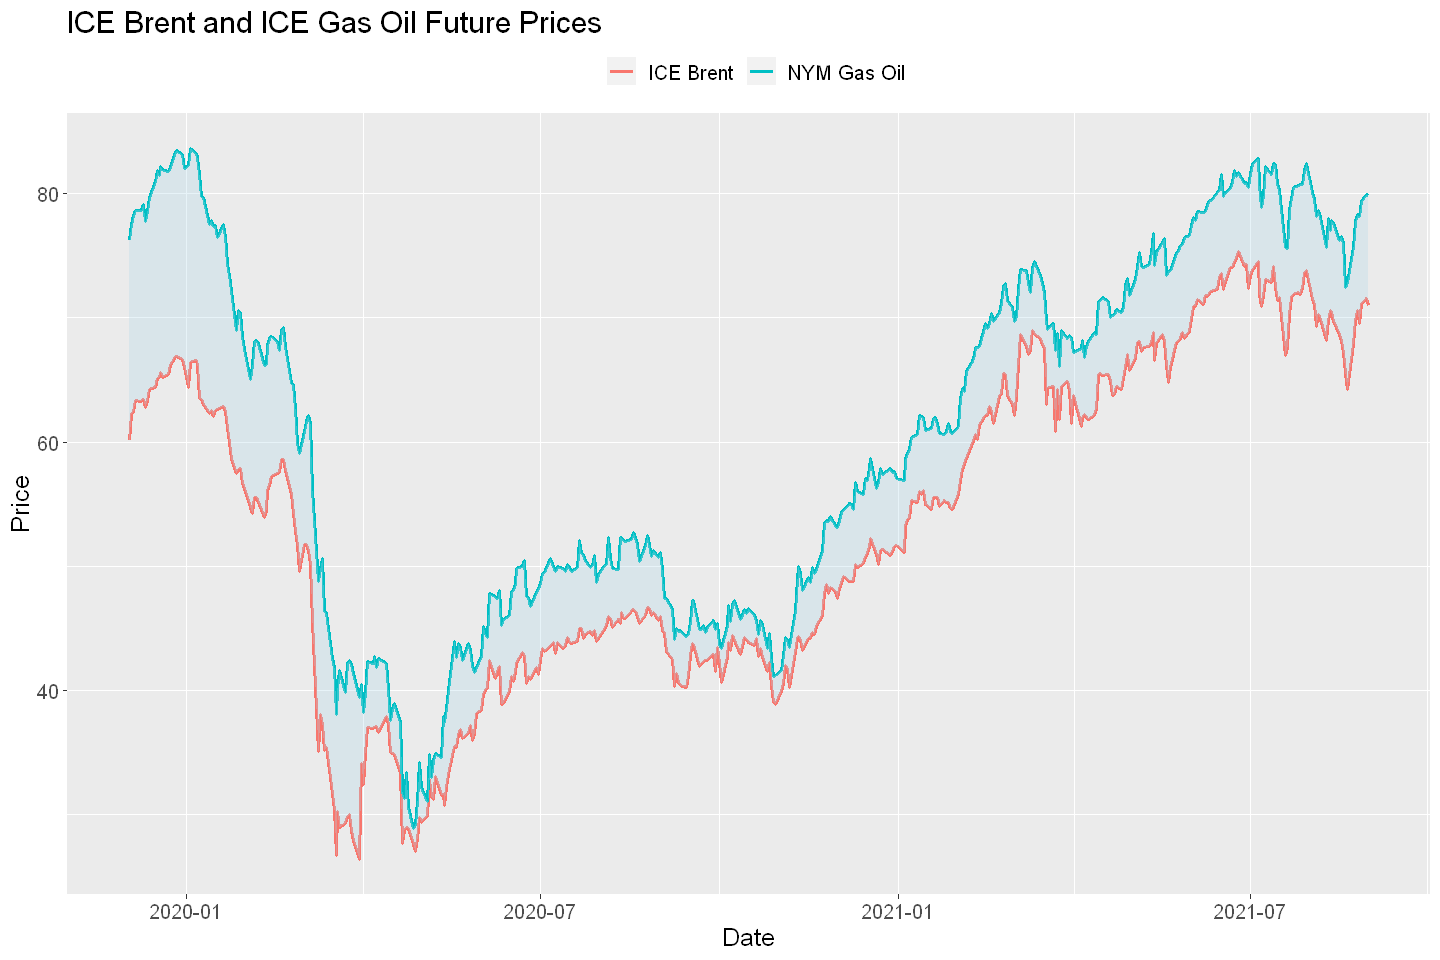

In [13]:
fig(12,8)
print(gas_oil_brent_price_plot)

### Are dates where an active contract is rolled outliers?

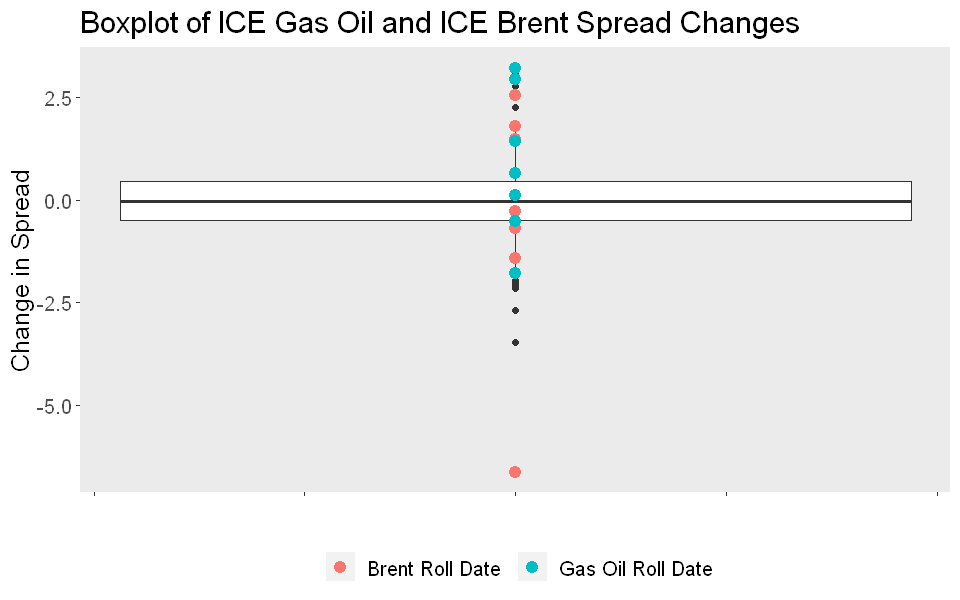

In [14]:
fig(8,5)
print(gas_brent_spread_chg_boxplot)

 It looks like the majority of roll dates are outliers so we will remove them. 

### Is there a difference when the brent contract has a higher time to termination than the gas oil contract?

In [15]:
print(gas_brent_variance_diff_test)
print(gas_brent_mean_diff_test)


	F test to compare two variances

data:  gas_brent_spread_chg_long and gas_brent_spread_chg_short
F = 1.0017, num df = 239, denom df = 192, p-value = 0.9939
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7636593 1.3087560
sample estimates:
ratio of variances 
          1.001727 


	Welch Two Sample t-test

data:  gas_brent_spread_chg_long and gas_brent_spread_chg_short
t = 0.54226, df = 411.44, p-value = 0.5879
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1119531  0.1972482
sample estimates:
   mean of x    mean of y 
-0.006548098 -0.049195674 



Both tests fail to reject the null hypothesis. It is unlikely that there is a material difference when brent is longer than gas oil. Going forward, we will not separate them.

### Are spreads normally distributed?

In [16]:
# Normality Test of all Spread Changes
ks.test(gas_brent_spread_chg_all, pnorm, mean = 0, sd = sd(gas_brent_spread_chg_all))
ks.test(gas_oil_brent_spread$future_spread, pnorm, mean = 0,sd = sd(gas_oil_brent_spread$future_spread))


	One-sample Kolmogorov-Smirnov test

data:  gas_brent_spread_chg_all
D = 0.050203, p-value = 0.2252
alternative hypothesis: two-sided



	One-sample Kolmogorov-Smirnov test

data:  gas_oil_brent_spread$future_spread
D = 0.73637, p-value < 2.2e-16
alternative hypothesis: two-sided


After excluding dates where a future is rolled to the next quarter, there is little evidence that spread changes are not normally distributed. The spread between ICE Brent Futures and ICE Gas Oil futures have very strong evidence that is not normall distributed. 

### Is volatility constant?

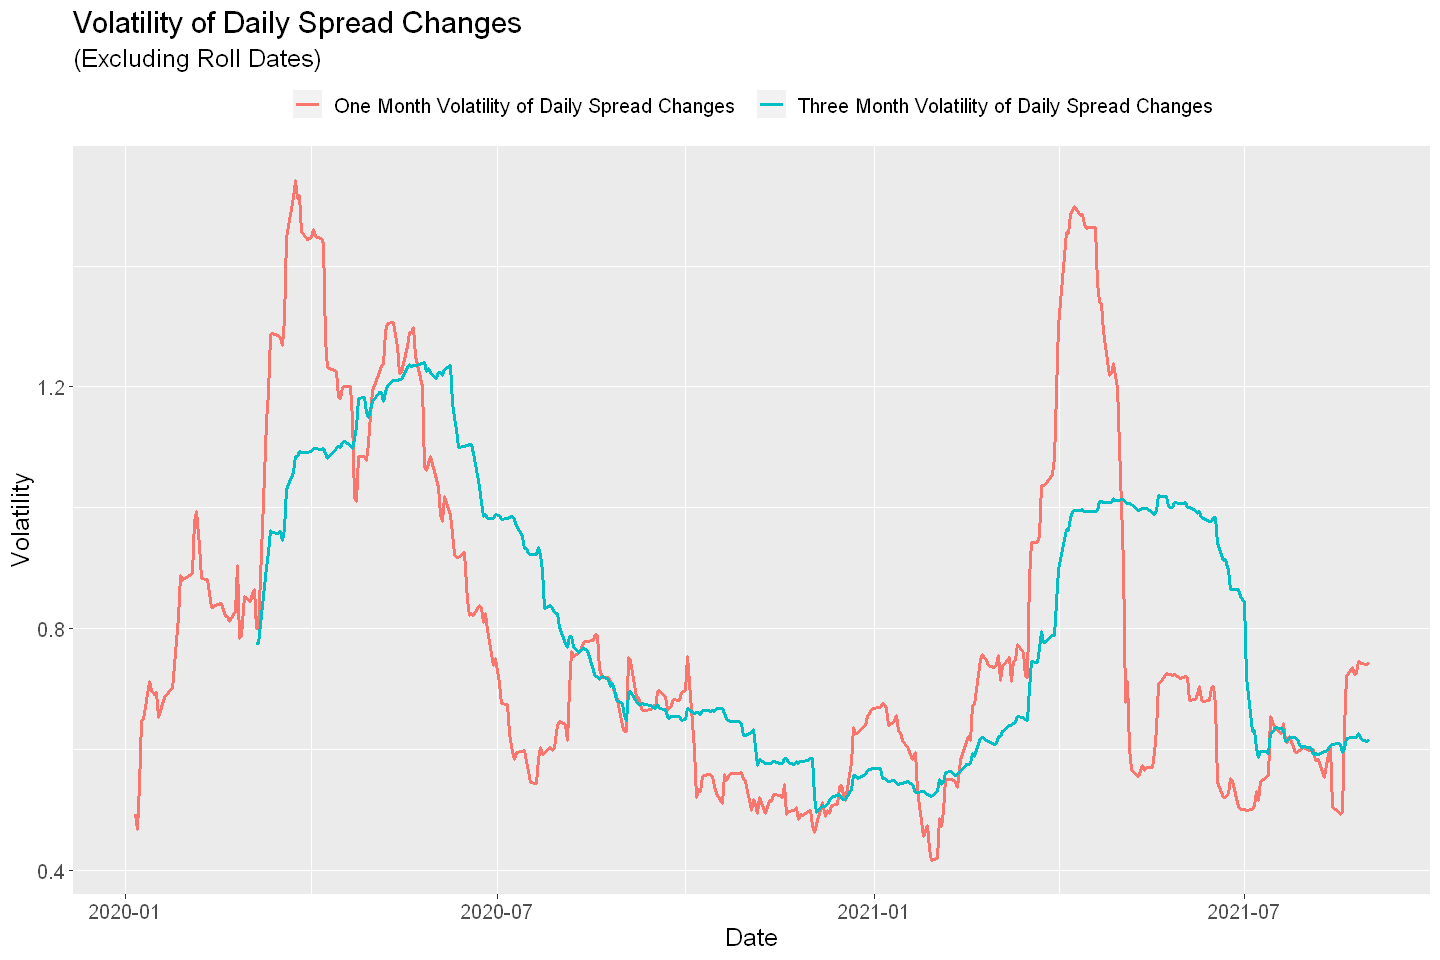

In [17]:
fig(12,8)
print(gas_brent_vol_plot)

### Is the brent gas oil spread mean reverting?

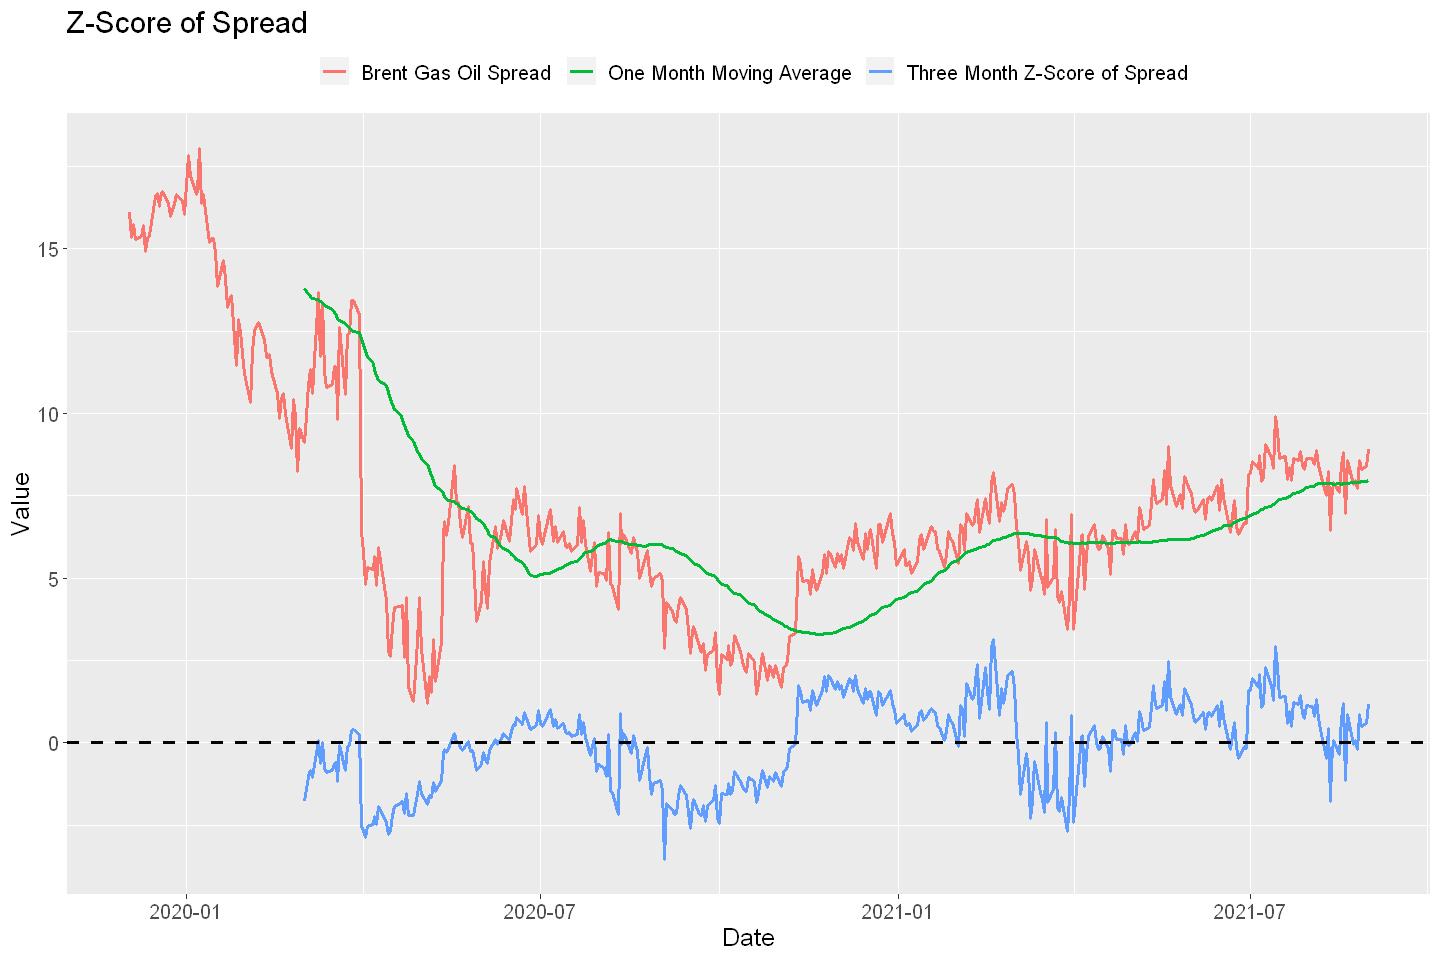



|Metric                           | Standard Deviation| 25th Percentile| Median Value| 75th Percentile|
|:--------------------------------|------------------:|---------------:|------------:|---------------:|
|Spread                           |               3.53|            5.16|         6.42|            8.26|
|Spread vs 1-Month Moving Average |               1.50|           -0.88|        -0.04|            0.67|
|Spread vs 3-Month Moving Average |               2.21|           -1.41|         0.24|            1.09|


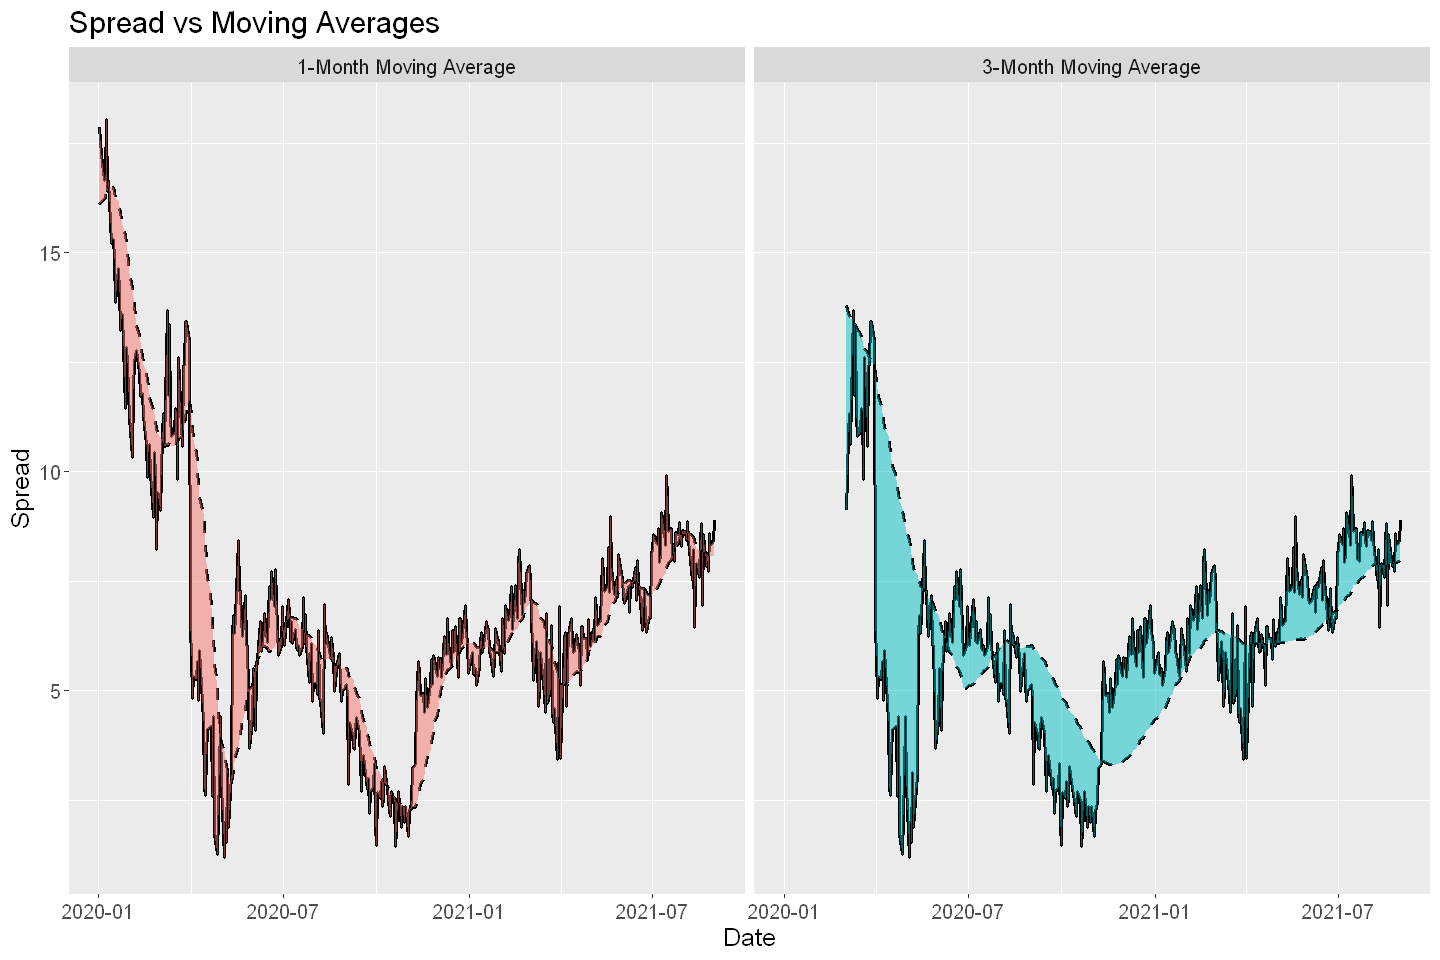

In [17]:
fig(12,8)
print(gas_brent_ma_plot)
print(gas_brent_spread_vs_ma_plot)

fig(15,8)
print(gas_brent_ma_metrics_table)

## Second: NYM Gasoline vs ICE Gas Oil

### ICE Brent vs ICE Gas Oil Data Processing

In [18]:
gas_oil_multiplier = (100 /118.35 / 264.172)

gas_oil_nym_gas_spread = nym_gas_2nd_month_futures %>%
    left_join(gas_oil_2nd_month_futures,by='Date') %>%
    mutate(gas_oil_2nd_month_adj = gas_oil_2nd_month*gas_oil_multiplier,
           future_spread = gas_oil_2nd_month_adj - nym_gas_2nd_month,
           DtT_classifier = if_else(gas_oil_DtT>nym_DtT,'longer','shorter'),
           spread_chg = future_spread-lag(future_spread,1),
           nym_roll = (nym_DtT-lag(nym_DtT,1))>(Date-lag(Date,1)),
           gas_oil_roll = (gas_oil_DtT-lag(gas_oil_DtT,1))>(Date-lag(Date,1))) %>%
            drop_na()

nym_rolls <- gas_oil_nym_gas_spread %>% filter(nym_roll)
gas_oil_rolls <- gas_oil_nym_gas_spread %>% filter(gas_oil_roll)

In [19]:
gas_oil_nym_price_plot <- gas_oil_nym_gas_spread %>%
    ggplot() +
    geom_line(aes(x=Date,y=nym_gas_2nd_month,col='NYM Gasoline'),size=1) +
    geom_line(aes(x=Date,y=gas_oil_2nd_month_adj,col='NYM Gas Oil'),size=1) +
    geom_ribbon(aes(x=Date,ymin = gas_oil_2nd_month_adj, ymax = nym_gas_2nd_month),fill='lightblue',alpha=0.3) +
    labs(title = 'NYM Gasoline and ICE Gas Oil Future Prices',y='Price') +
    theme(text = element_text(size=15),
    legend.title = element_blank(),
    legend.position = 'top')



In [20]:
gas_nym_spread_chg_long <- gas_oil_nym_gas_spread %>% 
  filter(!nym_roll&!gas_oil_roll) %>%
  filter(DtT_classifier=='longer') %>%
  select(spread_chg) %>%
  distinct() %>%
  pull(spread_chg)

gas_nym_spread_chg_short <- gas_oil_nym_gas_spread %>% 
  filter(!nym_roll&!gas_oil_roll) %>%
  filter(DtT_classifier=='shorter') %>%
  pull(spread_chg) %>%
  unique()

gas_nym_spread_chg_all <- gas_oil_nym_gas_spread %>% 
  filter(!nym_roll&!gas_oil_roll) %>%
  pull(spread_chg) %>% 
  unique()

In [36]:
gas_nym_spread_chg_boxplot <- gas_oil_nym_gas_spread %>%
  drop_na() %>%
  ggplot(aes(y=spread_chg)) + 
  geom_boxplot() +
  geom_point(data = nym_rolls,aes(x=0,col='NYM Gasoline Roll Date'),size=3) +
  geom_point(data = gas_oil_rolls,aes(x=0,col = 'Gas Oil Roll Date'),size=3) +
  labs(title='Boxplot of ICE Gas Oil and NYM Gasoline Spread Changes',
       y='Change in Spread',x='') +
  theme(legend.position = 'bottom',
      legend.title = element_blank(),
     panel.grid = element_blank(),
     axis.text.x = element_blank(),
        text = element_text(size=15))

In [22]:
gas_nym_variance_diff_test <- var.test(gas_nym_spread_chg_long,
                                             gas_nym_spread_chg_short,
                                             alternative = "two.sided")

gas_nym_mean_diff_test <- t.test(gas_nym_spread_chg_long,
                                       gas_nym_spread_chg_short,
                                       alternative = "two.sided")



In [23]:
gas_nym_ma_plot <- gas_oil_nym_gas_spread %>%
  mutate(zscore_qtr = rollapply(future_spread,width = 63,FUN = zscore,fill=NA, align='right'),
         spread_ma_1mo = rollapply(future_spread,width = 21,FUN = mean,fill=NA, align='right')) %>%
  select(Date,zscore_qtr,spread_ma_1mo, future_spread) %>%
  rename(`NYM Gasoline ICE Gas Oil Spread` = future_spread,
         `Three Month Z-Score of Spread` = zscore_qtr,
         `One Month Moving Average` = spread_ma_1mo) %>%
  pivot_longer(-Date, names_to = 'variable',values_to = 'value') %>%
  drop_na() %>%
  ggplot() +
  geom_line(aes(x=Date, y=value, col = variable), size=1) +
  geom_hline(yintercept=0, linetype = 'dashed', size=1) +
  labs(title = 'Z-Score of Spread',y='Value') +
  theme(legend.position = 'top',
       legend.title = element_blank(),
        text = element_text(size=15))

In [24]:
gas_nym_spread_vs_ma <- gas_oil_nym_gas_spread %>%
  mutate(spread_ma_1mo = rollapply(future_spread,width = 21,FUN = mean,fill=NA, align='right'),
         spread_ma_3mo = rollapply(future_spread,width = 63,FUN = mean,fill=NA, align='right'),
         spread_vs_ma_1mo = future_spread - spread_ma_1mo,
         spread_vs_ma_3mo = future_spread - spread_ma_3mo) %>%
  select(Date, future_spread, spread_ma_1mo, spread_ma_3mo, spread_vs_ma_1mo, spread_vs_ma_3mo)

gas_nym_ma_metrics_table <- gas_nym_spread_vs_ma %>% 
    select(Date,future_spread,spread_vs_ma_1mo, spread_vs_ma_3mo) %>%
    rename(Spread = future_spread,
           `Spread vs 1-Month Moving Average` = spread_vs_ma_1mo,
           `Spread vs 3-Month Moving Average` = spread_vs_ma_3mo) %>%
    pivot_longer(-Date, names_to = 'Metric') %>%
    group_by(Metric) %>%
    summarize(`Standard Deviation`=sd(value,na.rm = TRUE),
              `25th Percentile` = quantile(value, 0.25, na.rm = TRUE),
              `Median Value` = median(value,na.rm=TRUE),
              `75th Percentile` = quantile(value, 0.75, na.rm = TRUE)) %>%
    mutate_if(is.numeric, round,2) %>%
    kable()

gas_nym_spread_vs_ma_plot <- gas_nym_spread_vs_ma %>%
  select(Date,future_spread,spread_ma_1mo, spread_ma_3mo) %>%
  rename(`1-Month Moving Average`=spread_ma_1mo,
        `3-Month Moving Average`=spread_ma_3mo) %>%
  pivot_longer(-c(Date,future_spread)) %>%
  drop_na() %>%
  ggplot() +
  geom_line(aes(x=Date, y=future_spread), size=1) +
  geom_line(aes(x=Date, y=value),linetype = 'dashed', size=1) +
  geom_ribbon(aes(x=Date,ymin=value, ymax = future_spread,fill=name),alpha=0.5) +
  labs(title = 'Spread vs Moving Averages',y='Spread') +
  theme(legend.position = 'none',
       legend.title = element_blank(),
        text = element_text(size=15)) +
facet_wrap(~name)

In [25]:
gas_nym_vol_plot <- gas_oil_nym_gas_spread %>%
  filter(!nym_roll&!gas_oil_roll) %>%
  mutate(sd_1mo = rollapply(spread_chg,width = 21,FUN = sd,fill=NA, align='right'),
         sd_3mo = rollapply(spread_chg,width = 63,FUN = sd,fill=NA, align='right')) %>%
  select(Date,sd_1mo,sd_3mo) %>%
  rename(`One Month Volatility of Daily Spread Changes`=sd_1mo,
         `Three Month Volatility of Daily Spread Changes`=sd_3mo) %>%
  pivot_longer(-Date, names_to = 'variable',values_to = 'value') %>%
  drop_na() %>%
  ggplot() +
  geom_line(aes(x=Date, y=value, col = variable),size=1) +
  theme(legend.position = 'top',
        legend.title = element_blank(),
        text = element_text(size=15)) +
  labs(title = 'Volatility of Daily Spread Changes',
       subtitle = '(Excluding Roll Dates)',y='Volatility')


### Are dates where an active contract is rolled outliers?

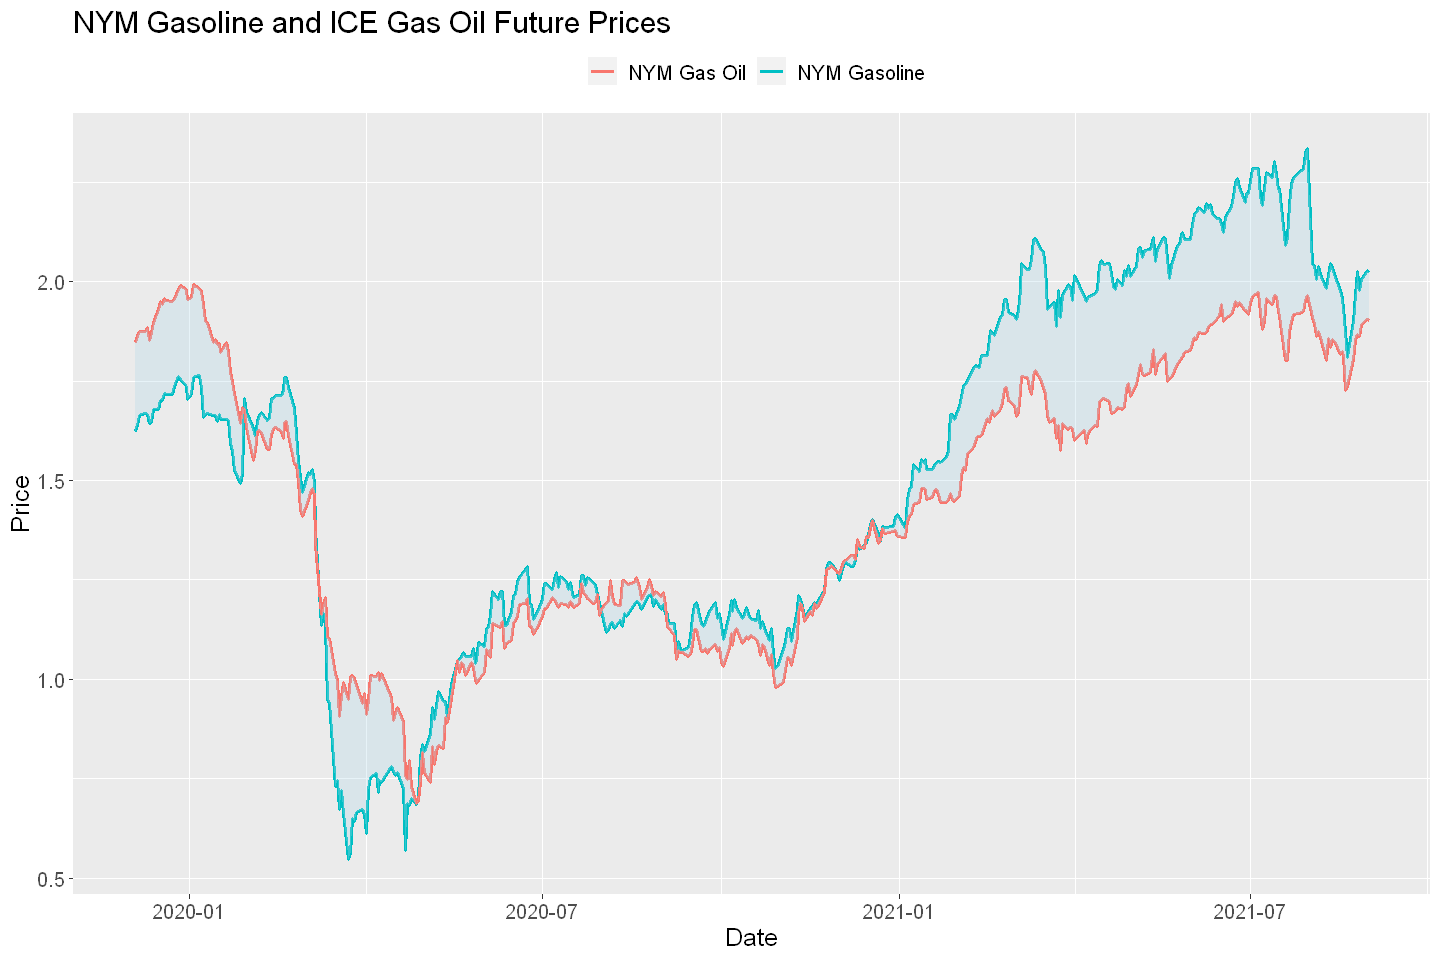

In [26]:
fig(12,8)
gas_oil_nym_price_plot

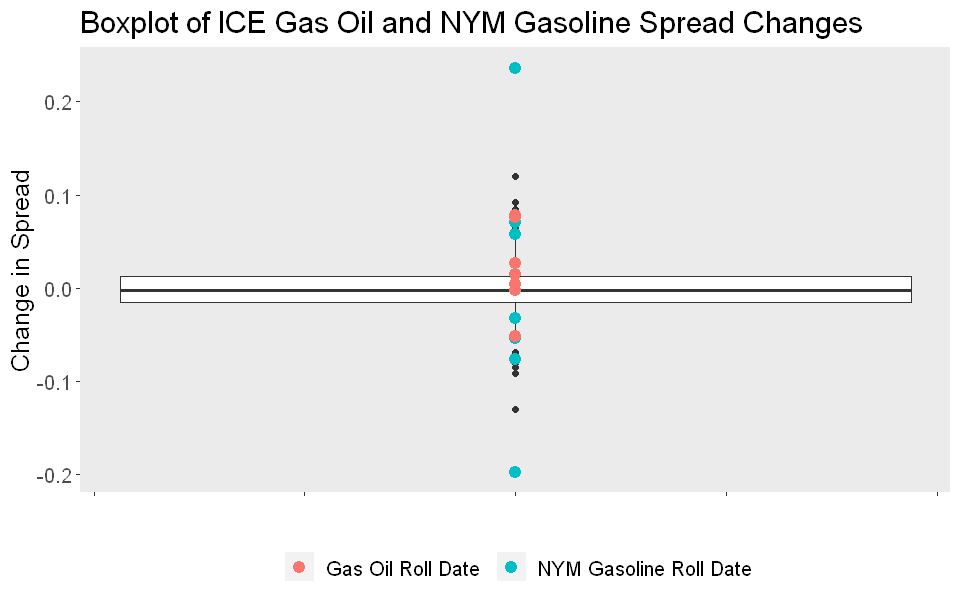

In [37]:
fig(8,5)
print(gas_nym_spread_chg_boxplot)

 It looks like the majority of roll dates are outliers so we will remove them. 

### Is there a difference when the brent contract has a higher time to termination than the gas oil contract?

In [28]:
print(gas_nym_variance_diff_test)
print(gas_nym_mean_diff_test)


	F test to compare two variances

data:  gas_nym_spread_chg_long and gas_nym_spread_chg_short
F = 1.3962, num df = 383, denom df = 47, p-value = 0.1608
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.873140 2.074275
sample estimates:
ratio of variances 
          1.396177 


	Welch Two Sample t-test

data:  gas_nym_spread_chg_long and gas_nym_spread_chg_short
t = 0.77566, df = 64.595, p-value = 0.4408
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.004176507  0.009479841
sample estimates:
   mean of x    mean of y 
-0.001006534 -0.003658201 



Both tests fail to reject the null hypothesis. It is unlikely that there is a material difference when brent is longer than gas oil. Going forward, we will not separate them.

### Are spreads normally distributed?

In [29]:
# Normality Test of all Spread Changes
ks.test(gas_nym_spread_chg_all,pnorm, mean = 0, sd = sd(gas_nym_spread_chg_all))

ks.test(gas_oil_nym_gas_spread$future_spread,
        pnorm,
        mean = 0,
        sd = sd(gas_oil_brent_spread$future_spread))


	One-sample Kolmogorov-Smirnov test

data:  gas_nym_spread_chg_all
D = 0.079774, p-value = 0.008186
alternative hypothesis: two-sided



	One-sample Kolmogorov-Smirnov test

data:  gas_oil_nym_gas_spread$future_spread
D = 0.45561, p-value < 2.2e-16
alternative hypothesis: two-sided


After excluding dates where a future is rolled to the next quarter, there is still evidence that spread changes are not normally distributed. The spread between NYM Gasoline Futures and ICE Gas Oil futures have very strong evidence that is not normall distributed. 

### Is volatility constant?

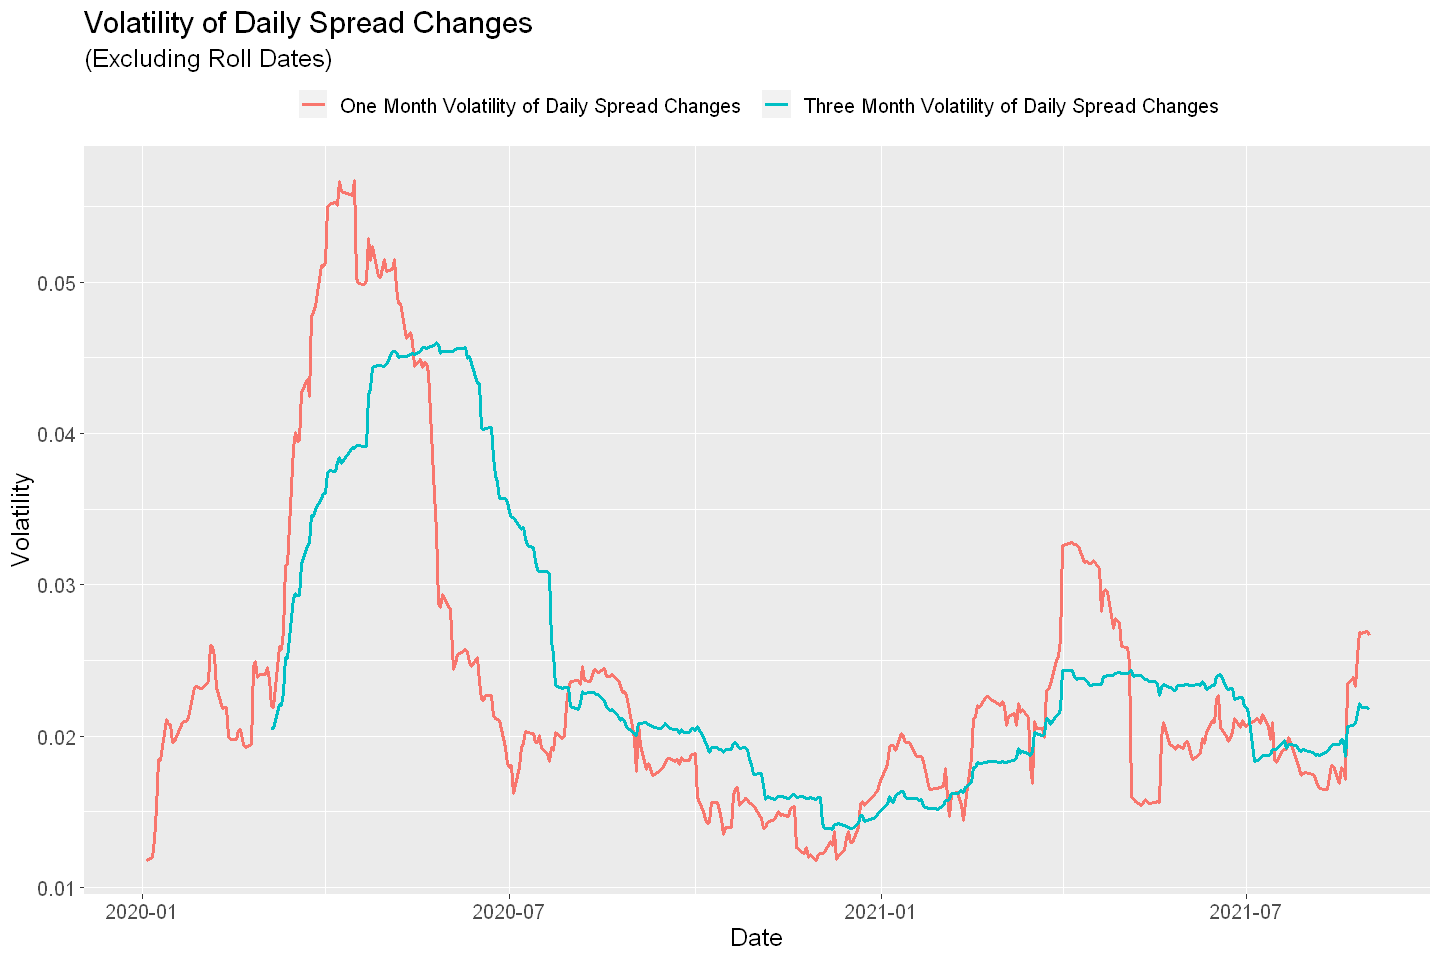

In [30]:
fig(12,8)
print(gas_nym_vol_plot)

Volatility does not appear to be constant over time.

### Is the brent gas oil spread mean reverting?

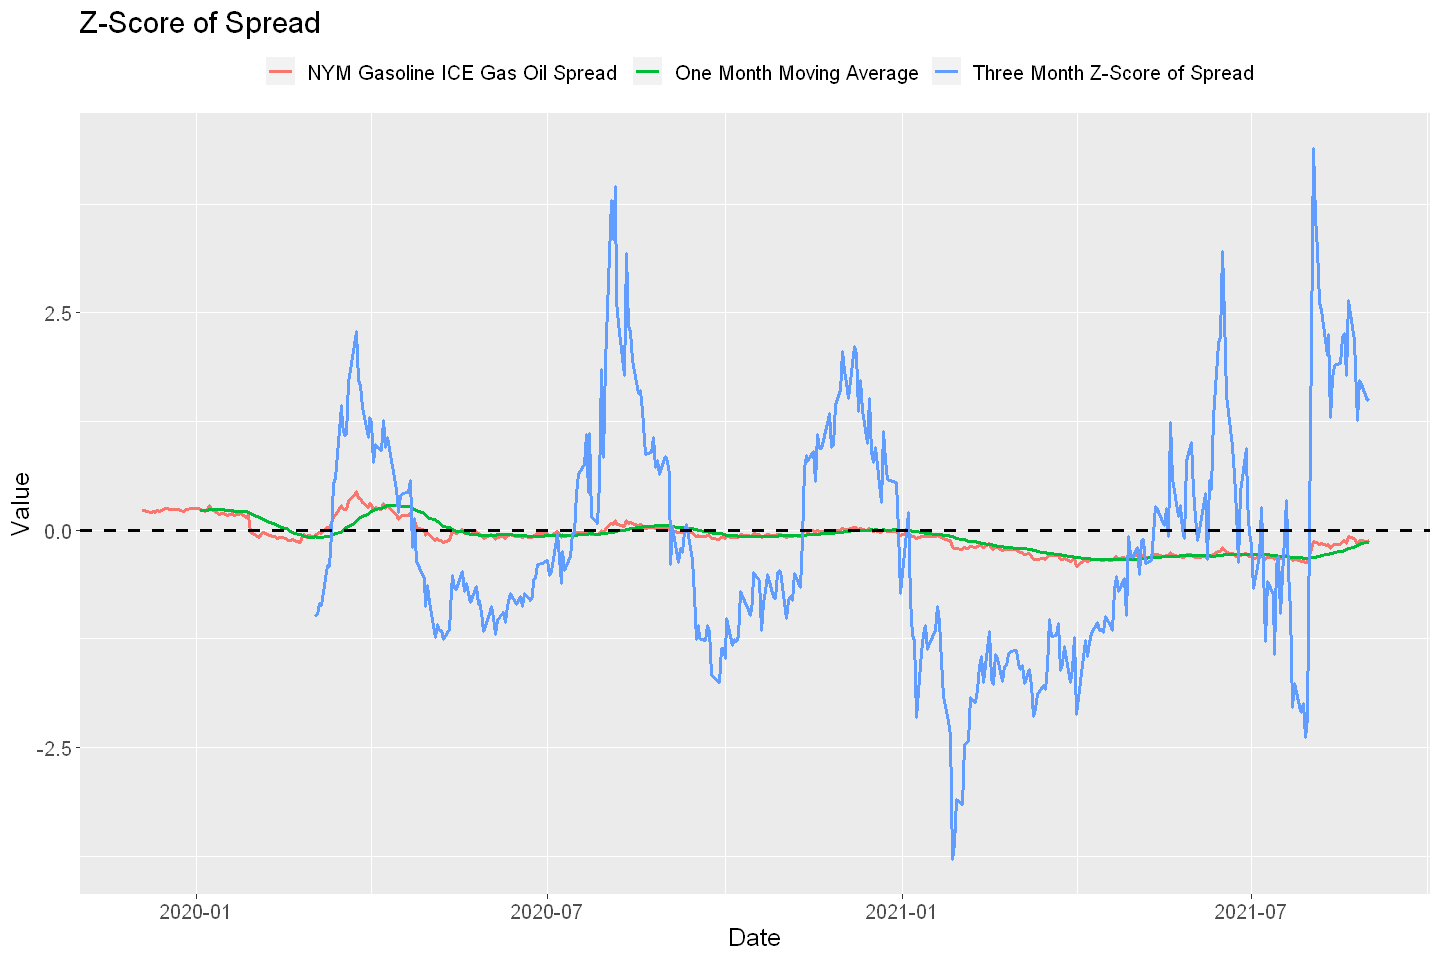



|Metric                           | Standard Deviation| 25th Percentile| Median Value| 75th Percentile|
|:--------------------------------|------------------:|---------------:|------------:|---------------:|
|Spread                           |               0.18|           -0.22|        -0.07|            0.00|
|Spread vs 1-Month Moving Average |               0.08|           -0.04|        -0.01|            0.02|
|Spread vs 3-Month Moving Average |               0.10|           -0.10|        -0.02|            0.04|


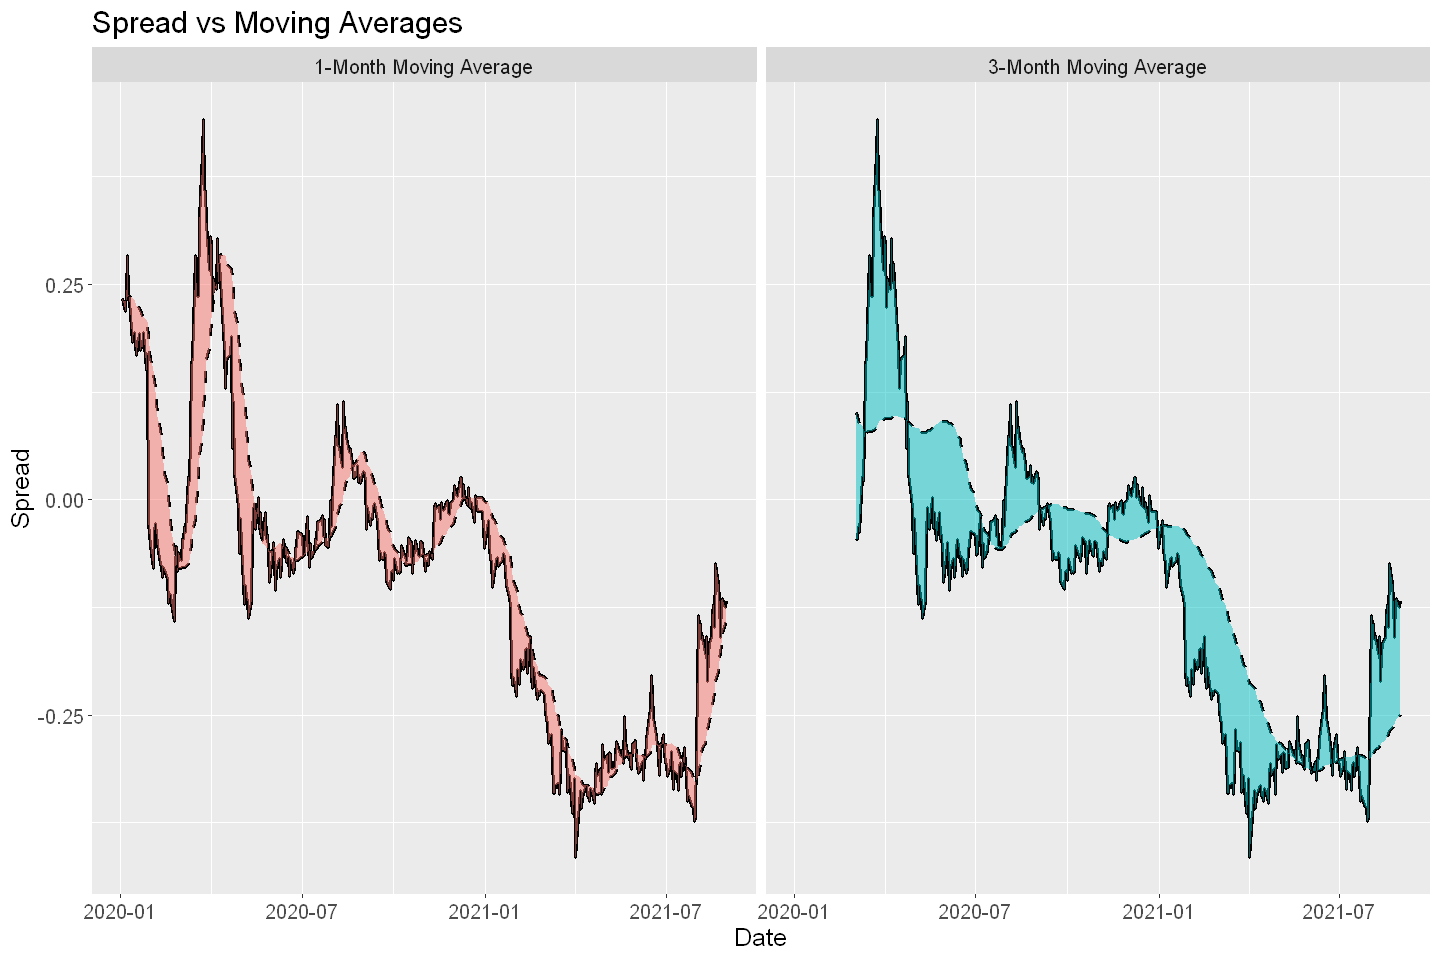

In [31]:
fig(12,8)
print(gas_nym_ma_plot)
print(gas_nym_spread_vs_ma_plot)

fig(15,8)
print(gas_nym_ma_metrics_table)

## Comparison of Spreads

In [32]:
gas_nym_dat <-  gas_oil_nym_gas_spread %>%
select(Date, future_spread, spread_chg) %>% 
rename(gas_oil_nym_gas_spread = future_spread,
      gas_oil_nym_gas_spread_chg = spread_chg)

gas_brent_dat <-  gas_oil_brent_spread %>%
select(Date, future_spread, spread_chg) %>% 
rename(gas_oil_brent_spread = future_spread,
      gas_oil_brent_spread_chg = spread_chg)

both_spreads <- gas_nym_dat %>% 
    left_join(gas_brent_dat,by='Date') %>%
    mutate(spread_difference = gas_oil_brent_spread-gas_oil_nym_gas_spread)

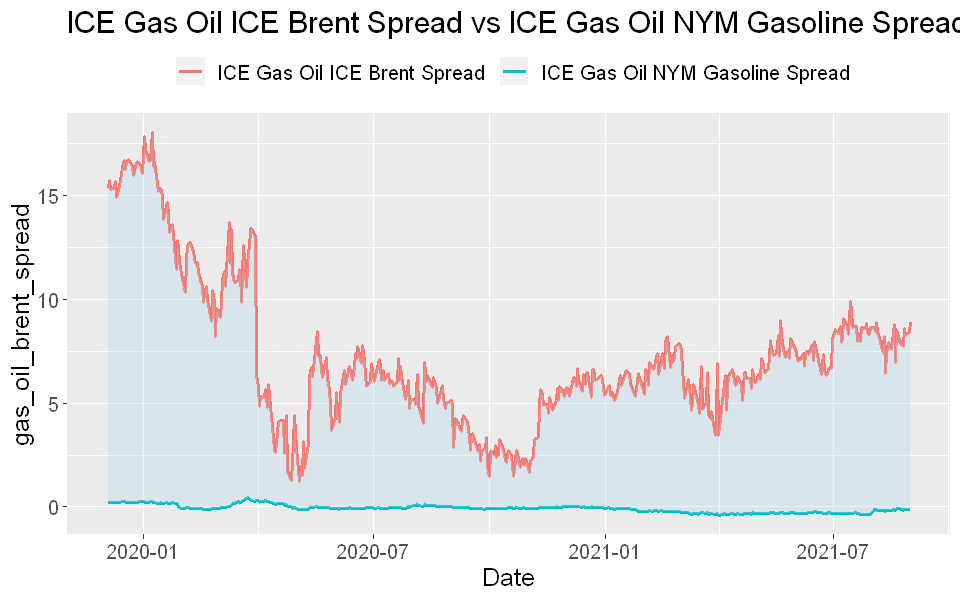

In [44]:
both_spreads %>%
    ggplot() +
    geom_line(aes(x=Date,y=gas_oil_brent_spread, col='ICE Gas Oil ICE Brent Spread'),size=1) +
    geom_line(aes(x=Date,y=gas_oil_nym_gas_spread, col='ICE Gas Oil NYM Gasoline Spread'),size=1) +
    geom_ribbon(aes(x=Date,ymin=gas_oil_nym_gas_spread,ymax=gas_oil_brent_spread),fill='lightblue',alpha=0.3) +
    theme(text = element_text(size=15),
         legend.title = element_blank(),
         legend.position = 'top') +
    labs(title = 'ICE Gas Oil ICE Brent Spread vs ICE Gas Oil NYM Gasoline Spread',
         ylab('Spread'))

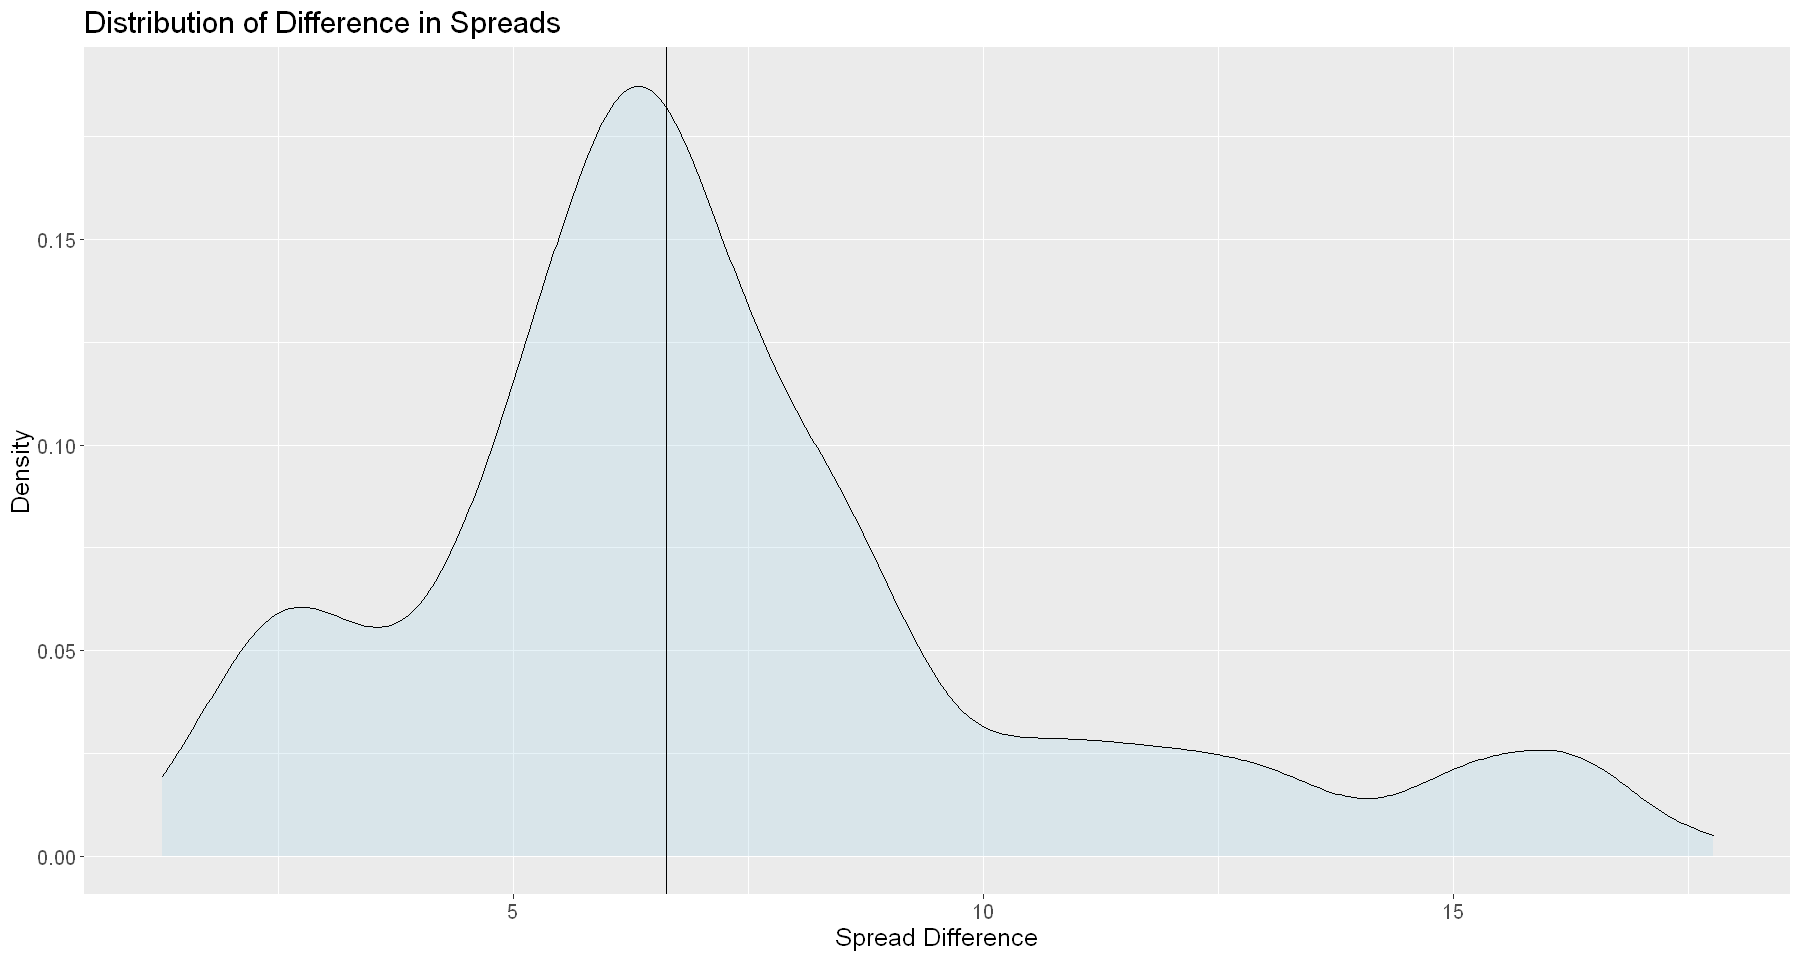

In [34]:
both_spreads %>%
    ggplot() +
    geom_density(aes(x=spread_difference),fill='lightblue',alpha=0.3) +
    geom_vline(aes(xintercept = median(spread_difference,na.rm=T))) +
    theme(text = element_text(size=15)) +
    labs(title = 'Distribution of Difference in Spreads',x='Spread Difference',y='Density')

In [35]:
both_spreads %>% 
    summarize(`Spread Correlation` = cor(gas_oil_brent_spread,gas_oil_nym_gas_spread),
              `Spread Change Correlation` = cor(gas_oil_brent_spread_chg, gas_oil_nym_gas_spread_chg),
              `25th Percentile` = quantile(spread_difference,0.25),
              `Median Spread Difference` = median(spread_difference),
              `75th Percentile` = quantile(spread_difference,0.75)) %>%
    mutate_all(round,2) %>%
    kable(caption = 'Statistics on Spread Differences')



Table: Statistics on Spread Differences

| Spread Correlation| Spread Change Correlation| 25th Percentile| Median Spread Difference| 75th Percentile|
|------------------:|-------------------------:|---------------:|------------------------:|---------------:|
|               0.38|                      0.53|            5.26|                     6.63|            8.44|

**Summary of Spread Comparision**

It appears that the two spreads are correlated. The daily spread changes show stronger correlation than the spread levels. Spreads between ICE gas oil and NYM gasoline are much tighter compared to ICE gas oil and ICE brent. I believe this is because they are different stage products. crude oil can be turned into gas oil (deisel) or gasoline but gas oil cannot be converted to gasoline.


**Potential Further Exploration**

I would be interested in exploring the impact of the forward curve structures and the spread between the contracts. If a forward curve is steep and there is a large difference in time to termination, I believe that could be explained by the structure of the forward curve.
